## Model training on given data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.metrics import *

rand_seed = 42

In [4]:
datapath = datapath = "/home/derekdb/notebooks/uw-geohack-challenge/data"
path = Path(datapath)/'training_data'

In [8]:
# I split training image into 448x672 tiles and manually segmentd all the images.
path_imgs = path/'images'
path_lbls = path/'label_images'

In [9]:
get_y_fn = lambda x: (path_lbls/x.stem).with_suffix('.png')

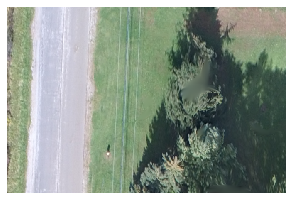

In [10]:
fnames = get_image_files(path_imgs)
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

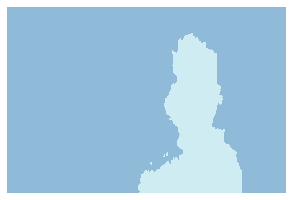

In [12]:
mask_f = get_y_fn(img_f)
mask = open_mask(mask_f)
mask.show(figsize=(5,5))

In [17]:
# create a list of validation data for network training
# fns = [x.name for x in fnames]
# from random import sample
# random.seed(rand_seed)
# valid_list = sample(fns, len(fns)//5)
# print(valid_list)
# with open(path/'valid.txt', 'w') as handle:
#     handle.write('\n'.join(valid_list))

['ortho_train_5_3.tif', 'ortho_train_4_7.tif', 'ortho_train_3_6.tif', 'ortho_train_9_7.tif', 'ortho_train_5_4.tif', 'ortho_train_9_6.tif', 'ortho_train_4_1.tif', 'ortho_train_11_7.tif', 'ortho_train_10_3.tif', 'ortho_train_4_2.tif']


In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([448, 672]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [14]:
codes = array(['Background', 'Tree'])

In [15]:
size = src_size//2

In [16]:
# learn.destroy()
gc.collect()
torch.cuda.empty_cache()
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4

print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 10960MB of GPU RAM free


In [18]:
src = (SegmentationItemList.from_folder(path_imgs)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [19]:
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

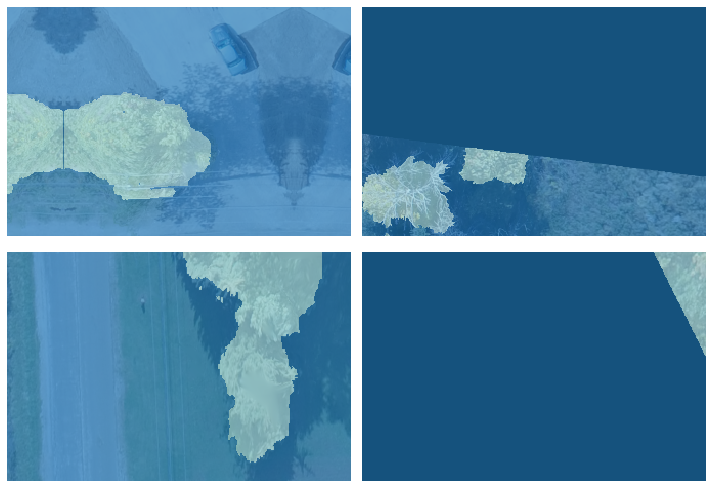

In [20]:
data.show_batch(2, figsize=(10,7), alpha=0.7)

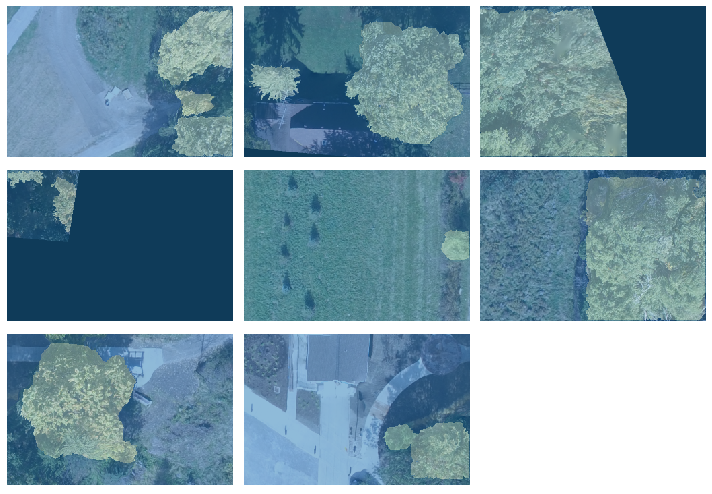

In [21]:
data.show_batch(5, figsize=(10,7), ds_type=DatasetType.Valid)

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
void_code

0

In [23]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
metrics=acc
# metrics=accuracy
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


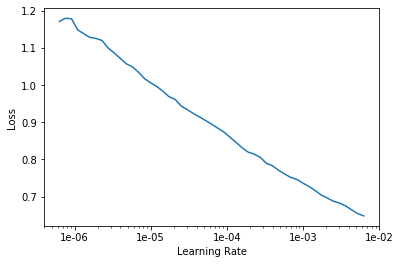

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr = 1e-3

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) 
learn.save('stage-1')

epoch,train_loss,valid_loss,acc,time
0,0.776683,0.576577,0.026841,00:14
1,0.660260,0.702446,0.894310,00:06
2,0.611912,0.435180,0.586768,00:06
3,0.549224,0.407860,0.973522,00:06
4,0.659845,0.437409,0.826852,00:06
5,0.613659,0.362748,0.372140,00:06
6,0.611491,0.498383,0.995304,00:06
7,0.595567,0.488468,0.000811,00:06
8,0.575209,0.366075,0.333274,00:06
9,0.546106,0.303401,0.781073,00:06


In [29]:
learn.load('stage-1');

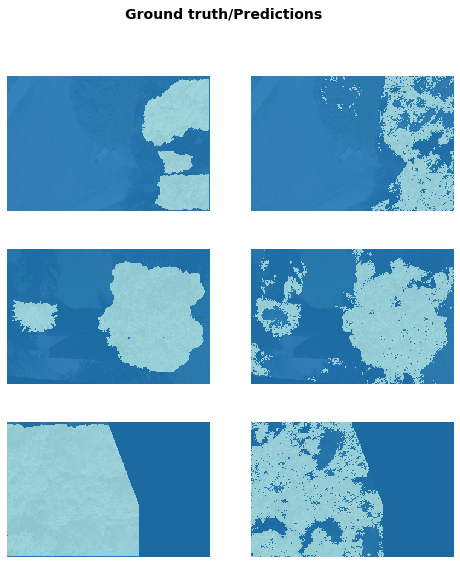

In [30]:
learn.show_results(rows=3, figsize=(8,9), alpha=0.9)

In [31]:
# unfreeze to update weights of the encoder
learn.unfreeze()

In [32]:
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)
learn.save('stage-2');

epoch,train_loss,valid_loss,acc,time
0,0.358783,0.295383,0.780768,00:07
1,0.361071,0.289834,0.831254,00:06
2,0.351496,0.270672,0.831190,00:06
3,0.347579,0.255984,0.880296,00:06
4,0.343583,0.257555,0.920715,00:06
5,0.333323,0.291643,0.952596,00:06
6,0.324918,0.234581,0.679768,00:06
7,0.319121,0.178518,0.918362,00:06
8,0.316333,0.279931,0.980962,00:06
9,0.316039,0.211422,0.814758,00:06


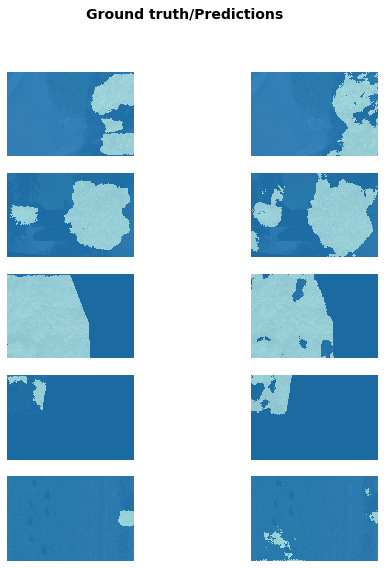

In [33]:
learn.show_results(rows=5, figsize=(8,9), alpha=0.9)

## Try on eval data

In [34]:
path_eval = Path(datapath)/'eval_data'
path_eval_imgs = path_eval/'patches'

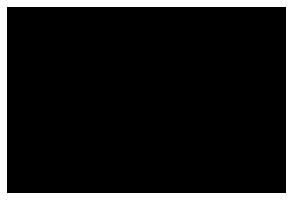

In [37]:
eval_fns = get_image_files(path_eval_imgs)
eval_img_f = eval_fns[0]
img = open_image(eval_img_f)
img.show(figsize=(5,5)) 

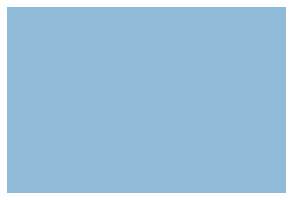

In [38]:
prediction = learn.predict(img)
prediction[0].show(figsize=(5,5))
# The image is blank so prediction should be blank

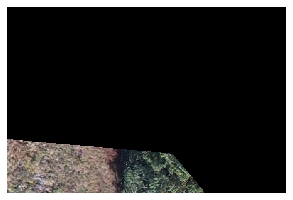

In [39]:
# try another image that's known to contain trees
img_f = '/home/derekdb/notebooks/uw-geohack-challenge/data/eval_data/patches/ortho_eval_11_6.tif'
img = open_image(img_f)
img.show(figsize=(5,5)) 

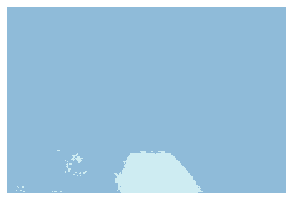

In [41]:
prediction = learn.predict(img)
prediction[0].show(figsize=(5,5))
# result shows that the tree is successfully segmented

In [42]:
# now that the model seems to be working, I'll run the model on all the eval images and call postprocessing 
# to stitch the mask patches together to give rise to the final result

In [47]:
path_lbl_patches = path_eval/'label_patches'
path_lbl_patches.mkdir(parents=True, exist_ok=True)
for f in eval_fns:
    img = open_image(f)
    prediction = learn.predict(img)
    prediction[0].save((path_lbl_patches/f.stem).with_suffix('.png'))


## fin